# **Population prediction via CNNs and geospatial imagery** #
### Spring 2020 | AM216 Final Project
### Kaela Nelson, Simon Warchol, Cameron Hickert
GitHub repository [here](https://github.com/chickert/geospatial_analysis)


#Abstract:

Google Earth Engine has a multi-petabyte catalog of open source satellite imagery and geospatial datasets available to scientists and researchers to analyze. One interesting problem is extracting demographic information from these satellite images, such as the population of a given area. Our goal is to build neural network models to estimate the population from satellite images. This is a difficult task, as the model must learn land use types within an image in order to identify high- versus low-population areas. Previous sources have worked on a similar problem using deep sequential models and UNet architectures. We expand this by building many models including FFNNs, CNNs, UNets, and also investigating the value of transfer learning for this task.

# Introduction #
Our group is interested in the combination of machine learning methods and satellite imagery. The amount of data in this space (pun intended) is already remarkable, and growing rapidly. In addition to the large datasets released from government-affiliated science organizations -- such as NASA/USGS' Landsat image collection or the EU Copernicus program's Sentinel data hub -- the proliferation of privately-held "constellations" is now contributing to the growing data pool. Simultaneously, improvements in image analysis driven by machine learning methods make gleaning insights from this relatively-unstructured data more feasible than ever. 

For our project, our group assesses the performance of neural networks in predicting a US census tract's population with only raw RGB pixel data collected from the Copernicus satellite program's geospatial imagery. For the context of this project, we will limit our anlaysis to Massachusetts, though we expect that our results are relevant beyond the state's borders. On an even broader level, we hope that the general process and data pipeline used to implement our project could be adapted relatively easily to a much wider variety of predicton tasks using geospatial data from Google's Earth Engine. 


# Background and Data Sources #
## 2010 Census Data ##
Every 10 years, the United States conducts a census and releases this information to the public. The highest level of granularity in this information is a "census block", which is roughly the size of a city block. Census blocks are, in turn, part of census tracts, which vary significantly in size depending on population density, but in urban areas, are roughly the size of a neighborhood and contain somewhere between [1,200 and 8,000 inhabitants](https://www2.census.gov/geo/pdfs/education/CensusTracts.pdf).

## Cenpy ##

The 2010 Census is massive, and as such, we used CenPy (https://cenpy-devs.github.io/) to easily query this dataset for the information we wanted. CenPy is built with Geopandas (https://geopandas.org/), which allows for easy data manipulation and discovery.

Below, we install CenPy and pull back information about every tract in the state of Massachusetts. 

Specifically, note the variable paramater, which controls which data we get back from the census, for example `variables=['H006002', 'P001001']`. Every variable is defined [here](https://api.census.gov/data/2010/dec/sf1/variables.html). In this example the code is pulling back
`H006002` which corresponds to "Average household size!!Renter occupied"
and `P001001` which corresponds to "Total Population". In the code block below we pull back the population data using this second variable.

It should again be noted that aggregating this information using the raw census data would be slow and somewhat computationally expensive; thus, using CenPy is preferred.


In [0]:
!apt install libspatialindex-dev
!pip install cenpy
import cenpy
massachusetts = cenpy.products.Decennial2010().from_state('Massachusetts',  variables=['P001001'], level="tract")
massachusetts.head()


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_str

,GEOID,geometry,P001001,NAME,state,county,tract
0,25003900500,"POLYGON ((-8164047.000 5223901.510, -8164034.4...",3288.0,"Census Tract 9005, Berkshire County, Massachus...",25,003,900500
1,25003900700,"POLYGON ((-8163198.520 5223708.800, -8163079.4...",2910.0,"Census Tract 9007, Berkshire County, Massachus...",25,003,900700
2,25003925100,"POLYGON ((-8172449.060 5194777.890, -8172189.2...",7104.0,"Census Tract 9251, Berkshire County, Massachus...",25,003,925100
3,25003922300,"POLYGON ((-8145723.810 5251058.820, -8145707.7...",2116.0,"Census Tract 9223, Berkshire County, Massachus...",25,003,922300
4,25013812903,"POLYGON ((-8104159.120 5180706.160, -8104021.3...",2593.0,"Census Tract 8129.03, Hampden County, Massachu...",25,013,812903


Now we filter this to only look at one of our group member's Census tract in Cambridge, MA, which is in `state = 25`, `county=017`, `tract = 353300`

---




In [0]:
massachusetts[(massachusetts['state'] == '25') & (massachusetts['county'] == '017') & (massachusetts['tract'] == '353300')]

,GEOID,geometry,P001001,NAME,state,county,tract
1384,25017353300,"POLYGON ((-7916716.800 5214453.580, -7916715.9...",3471.0,"Census Tract 3533, Middlesex County, Massachus...",25,017,353300


Thus we see that this census tract has a total population of 3,471. 

## Google Earth Engine
Google Earth Engine allows for easy access to a vast array of satellite imagery, and -- importantly for our project -- also contains geometries of Census Tracts and Census Blocks. Below we authenticate Earth Engine to run within this Colab notebook.


In [0]:
import ee

In [0]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=j-kKiNSlwTdtuKALjNt1MViT2J8Hu8Y4G2DS5m73y-Y&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/zwGhbYAA8n2V7_ylfSU0Z1LZKN9NegQ5UoPmYXxdrhA1_0HKEumwHKA

Successfully saved authorization token.


We will also allow this to read and write from Google Drive, and then import the `folium` library to visualize maps.

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
import folium
print(folium.__version__)

0.8.3


## Satellite Images


### Landsat
The USGS and NASA's Landsat satelites have been taking pictures of the world since the 1970s. The two most recent satellites, Landsat 7 and 8, are both integrated with Earth Engine, and provide a vast array of imformation such a surface reflection, burn, vegatation, and temperature information.

Ultimately -- and as we describe below -- we elected to go with data from the EU's Copernicus program. However, it is instructive to first provide some insight into our investigation of the Landsat data (especially for readers considering alternative projects with geospatial data), so we provide that description below. See further below for the data processing we do with the Copernicus dataset, which we ultimately used for our project. 

In both cases, we rely strictly on the RGB bands from the surface reflection data, which correspond to bands 2,3, and 4.

Given our Census data is from 2010, we initially wanted to get data from as close to 2010 as possible, which would come from Landsat 7, which has been recording images since 1999.



### Removing Clouds
One consideration when working with satellite images is the presense of clouds in many images. To combat this, we mask them via bitshifting with a method  adaped from this [notebook](https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/AI_platform_demo.ipynb).


In [0]:
# Cloud masking function.
fc = ee.FeatureCollection('TIGER/2016/States').filter(ee.Filter.eq('NAME', 'Massachusetts'))
test = fc.getInfo()['features']
feature = ee.Feature(test[0])
aoi = feature.geometry()
L8SR = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")
BANDS = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Cloud masking function.
# Cloud masking function.
def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  return image.updateMask(mask).select(BANDS).divide(10000)

# The image input data is a 2018 cloud-masked median composite.
image = L8SR.filterDate('2013-01-01', '2013-12-31').map(maskL8sr).median().clip(aoi)

# Use folium to visualize the imagery.
mapid = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[42.3612549,-71.1088637])

folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

Note the map above, which has a map of Massachusetts with clouds removed.

Now we will examine the specific census tract in Cambridge, MA that we pinpointed before. The geometries of every US census tract are accessible via https://developers.google.com/earth-engine/datasets/catalog/TIGER_2010_Tracts_DP1, which also includes some additional information about each tract.

In [0]:

# Cloud masking function.
fc = ee.FeatureCollection('TIGER/2016/States').filter(ee.Filter.eq('NAME', 'Massachusetts'))
test = fc.getInfo()['features']
feature = ee.Feature(test[0])
aoi = feature.geometry()
L8SR = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")
BANDS = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Cloud masking function.
# Cloud masking function.
def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  return image.updateMask(mask).select(BANDS).divide(10000)

# The image input data is a 2018 cloud-masked median composite.
image = L8SR.filterDate('2013-01-01', '2013-12-31').map(maskL8sr).median().clip(aoi)

# Use folium to visualize the imagery.
mapid = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[42.3612549,-71.1088637])

folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

In [0]:
fc = ee.FeatureCollection("TIGER/2010/Tracts_DP1").filter(ee.Filter.eq('geoid10', '25017353300'))
print(fc.size().getInfo())
test = fc.getInfo()['features']
feature = ee.Feature(test[0])
aoi = feature.geometry()
print(fc.size().getInfo())
L8SR = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")
BANDS = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']

# Cloud masking function.
# Cloud masking function.
def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  return image.updateMask(mask).select(BANDS).divide(10000)

# The image input data is a 2018 cloud-masked median composite.
image = L8SR.filterDate('2013-01-01', '2013-12-31').map(maskL8sr).median().clip(aoi)

# Use folium to visualize the imagery.
mapid = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[42.3612549,-71.1088637], zoom_start=15)

folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)
map.add_child(folium.LayerControl())
map


1
1


Above is the census tract. Unfortunately, this image is much blurrier than anticipated. A quick investigation reveals that Landsat has a resolution of 30 meters per pixel, which seems suboptimal for the purpose of pulling information from at the lowest level. As such, we decided to move to another satellite image source found on Earth Engine, the EU's Copernicus Sentinel-2 satellite (https://earth.esa.int/web/sentinel/user-guides/sentinel-2-msi/resolutions/radiometric), which has a resolution of 10 meters per pixel, which we believe is better for our analysis.

It should be noted that the images that Google uses for Google Earth and Google Maps are **not** licensed for use on Earth Engine, and are provided by DigitalGlobe. These images are as good as 0.31 meters per pixel, but are not free for use and are licensed by Google. As we detail below, accessing this data would be one path worth pursuing in future projects to improve the models' performance. 

### Copernicus
Cambridge census tract using the [Copernicus Sentinel-2 Surface Reflection data](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR) as the image source.

In [0]:
fc = ee.FeatureCollection("TIGER/2010/Tracts_DP1").filter(ee.Filter.eq('geoid10', '25017353300'))
print(fc.size().getInfo())
test = fc.getInfo()['features']
feature = ee.Feature(test[0])
aoi = feature.geometry()
print(fc.size().getInfo())
image = ee.ImageCollection('COPERNICUS/S2_SR').filter(ee.Filter.calendarRange(4,10,'month')).filterBounds(aoi).filterMetadata('CLOUD_COVERAGE_ASSESSMENT', 'less_than', 30)
image = image.median().clip(aoi)

mapid = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2000})
map = folium.Map(location=[42.3612549,-71.1088637], zoom_start=15)

folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)
map.add_child(folium.LayerControl())
map


1
1


As one can see, this image is significantly higher resolution than the Landsat 7 image. Moreover, the process of removing cloud is easier as Copernicus computes a `CLOUD_COVERAGE_ASSESSMENT`. Thus, in the code above, we filter to focus on the census block, and then take the median of all images of that geography with a `CLOUD_COVERAGE_ASSESSMENT` of less than 30. 

One limitation here is that images are not availble from the earlier part of of the 2010s. Thus, one key issue with our subsequent analyses is that that the images are not from the same year as the data.

# Data Pipeline
## Saving Images
While Earth Engine does provide native functionality for exporting images to Tensorflow/Keras, we found it was actually easier to simply export each image as a PNG, thus creating a layer abstraction between our models and the data itself. This also made it easier to share the dataset amongst our group members, and the .png files made for a familiar format for use in our models. We exported the images in the following manner, labeling each tract by its `geoid`.



First, pull back each tract's data

In [0]:
!apt install libspatialindex-dev
!pip install cenpy
import cenpy
massachusetts = cenpy.products.Decennial2010().from_state('Massachusetts',  variables=['P001001'], level="tract")
massachusetts.head()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,GEOID,geometry,P001001,NAME,state,county,tract
0,25003900500,"POLYGON ((-8164047.000 5223901.510, -8164034.4...",3288.0,"Census Tract 9005, Berkshire County, Massachus...",25,003,900500
1,25003900700,"POLYGON ((-8163198.520 5223708.800, -8163079.4...",2910.0,"Census Tract 9007, Berkshire County, Massachus...",25,003,900700
2,25003925100,"POLYGON ((-8172449.060 5194777.890, -8172189.2...",7104.0,"Census Tract 9251, Berkshire County, Massachus...",25,003,925100
3,25003922300,"POLYGON ((-8145723.810 5251058.820, -8145707.7...",2116.0,"Census Tract 9223, Berkshire County, Massachus...",25,003,922300
4,25013812903,"POLYGON ((-8104159.120 5180706.160, -8104021.3...",2593.0,"Census Tract 8129.03, Hampden County, Massachu...",25,013,812903


Below we download a 512 x 512 version of the images. 

In [0]:
import os.path
from tqdm.auto import tqdm
grouped = massachusetts.groupby(['tract', 'county'])
tracts = grouped[['tract', 'county']]
def save_tract_image(tract):
  (this_tract, this_county) = tract[0]
  geoid = '25'+this_county+this_tract
  save_path = "/content/drive/My Drive/summer_retry/"+geoid+".png"
  if os.path.exists(save_path):
    pass
  else:
    fc = ee.FeatureCollection("TIGER/2010/Tracts_DP1").filter(ee.Filter.eq('geoid10', geoid))
    test = fc.getInfo()['features']
    feature = ee.Feature(test[0])
    aoi = feature.geometry()
    image = ee.ImageCollection('COPERNICUS/S2_SR').filter(ee.Filter.calendarRange(4,10,'month')).filterBounds(aoi).filterMetadata('CLOUD_COVERAGE_ASSESSMENT', 'less_than', 30)
    image = image.median().clip(aoi)
    parameters = {'min': 0, 
                'max': 2000,
                'dimensions': 512,
                'bands': ['B4', 'B3', 'B2'],
                'region':aoi}
    url = image.getThumbUrl(parameters)
    # urllib.request.urlretrieve(url, "/content/drive/My Drive/summer_retry/"+geoid+".png")


for tract in tqdm(tracts):
  save_tract_image(tract)

KeyboardInterrupt: ignored

One potential issue with this approach is that we create a 512x512 image of every census tract, despite the fact that tracts' land areas can differ significantly. One thing we can do to potentially combat this is to also record the area of each tract, and later feed that as another parameter into the models. We try this later in the experiments section. Thus, below we will create a dictionary of each tract and and its area, as calculated by the the area of the geometry in Earth Engine (which has a convenient built-in method to do so). We divide by `1000 * 1000` to convert the area from square meters to square kilometers. 

In [0]:
import os.path

grouped = massachusetts.groupby(['tract', 'county'])
tracts = grouped[['tract', 'county']]
tract_areas = {}
def extract_tract_area(tract):
  (this_tract, this_county) = tract[0]
  geoid = '25'+this_county+this_tract
  fc = ee.FeatureCollection("TIGER/2010/Tracts_DP1").filter(ee.Filter.eq('geoid10', geoid))
  test = fc.getInfo()['features']
  feature = ee.Feature(test[0])
  aoi = feature.geometry()
  tract_areas[geoid] = aoi.area().divide(1000 * 1000).getInfo();


for tract in tqdm(tracts):
  extract_tract_area(tract)

KeyboardInterrupt: ignored

To prevent having to run this again, let me pickle it.


In [0]:
# import pickle
# pickle.dump( tract_areas, open( "/content/drive/My Drive/areas.p", "wb" ) )

In [0]:
import pickle

tract_areas = favorite_color = pickle.load( open( "/content/drive/My Drive/AM216/geospatial_analysis/data/areas.p", "rb" ))


Another issue is the images are not the same size, though their largest dimension is 512. For example, some may be 459x512, or 500x512. We thus create a function to pad the images like so:

In [0]:
def pad_images(x):
  padded_x = np.zeros((512,512,3), dtype=np.uint8)
  x0 = x

  if x0.shape[0] != 512:
    pad_left = (512 - x0.shape[0])//2
    pad_right = x0.shape[0]+pad_left
    padded_x[pad_left:pad_right, :x0.shape[1],:] = x0

  if x0.shape[1] != 512:
    pad_top = (512 - x0.shape[1])//2
    pad_bottom = x0.shape[1]+pad_top
    padded_x[:x0.shape[0], pad_top:pad_bottom,:] = x0
  return np.array(padded_x)
  

Here is a sample of the padded images:

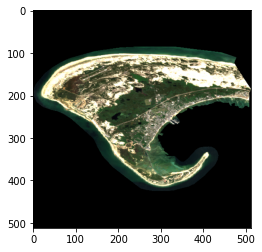

In [0]:
import imageio
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
im = imageio.imread('/content/drive/My Drive/summer_resized/25001010100.png')
plt.imshow(im)

### Tensorflow Data
Given the size of the images, storing all of them in memory is not feasible. We thus leverage Tensorflow's `ImageDataGenerator` and `flow_from_dataframe` methods, which allow us to use an auxiliary Pandas dataframe containing the filename of the image as well as the population figure.

First we will create this DataFrame, using CenPy

In [0]:
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import h5py
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pathlib

import folium
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Input, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam, SGD
from matplotlib import pyplot as plt

import os
from tensorflow.python.platform import gfile
from tensorflow.python.lib.io import file_io
from io import BytesIO
data_dir = pathlib.Path('/content/drive/My Drive/summer_resized/')

# list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
image_count = len(list(data_dir.glob('*.png')))
print(image_count)
IMAGE_NAMES = np.array([item.name for item in data_dir.glob('*.png') if item.name != "LICENSE.txt"])
print(IMAGE_NAMES)
POPULATION_VALS = []
for filename in tqdm(IMAGE_NAMES):
  state = filename[:2]
  county = filename[2:5]
  tract = filename[5:-4]
  pop = massachusetts[(massachusetts['state'] == state) & (massachusetts['county'] == county) & (massachusetts['tract'] == tract)].P001001.values[0]
  POPULATION_VALS.append((filename,pop))
pop_df = pd.DataFrame(POPULATION_VALS, columns =['filename', 'population']) 



1478
['25013812401.png' '25013812403.png' '25013812404.png' ...
 '25013812201.png' '25013812202.png' '25013812300.png']


In [0]:
BATCH_SIZE = 16
IMG_HEIGHT = 256
IMG_WIDTH = 256
image_dir = '/content/drive/My Drive/summer_resized'

STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Now create the ImageDataGeneator, which will allow us to flow images.

In [0]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split=0.2) 

Finally, we create the generators for the training and validation.

In [0]:
train_generator = train_datagen.flow_from_dataframe(dataframe=pop_df, directory=image_dir, 
                                              x_col="filename", y_col="population", has_ext=True, 
                                              class_mode="other", target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              shuffle=True,
                                              batch_size=BATCH_SIZE,subset='training')

Found 1183 validated image filenames.


In [0]:
 validation_generator = train_datagen.flow_from_dataframe(dataframe=pop_df, directory=image_dir, 
                                              x_col="filename", y_col="population", has_ext=True, 
                                              class_mode="other", target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=BATCH_SIZE,subset='validation')


Found 295 validated image filenames.


# Models
**Note:** The weights for our models are on our github repository, found [here](https://github.com/chickert/geospatial_analysis).



## FFNN
Our first model was a simple feed-forward neural network. This models flattens the image and then has two dense layers, before ouputting a number using linear activation. Note the summary below


In [0]:
input1 = Input(shape=(512,512,3))
flat = Flatten()(input1)
dense1 = Dense(32, activation='relu')(flat)
dense2 = Dense(32, activation='relu')(dense1)
output = Dense(1, activation='linear')(dense2)
FFNN = Model(inputs=input1, outputs=output)
FFNN.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 512, 512, 3)]     0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 786432)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                25165856  
_________________________________________________________________
dense_21 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 25,166,945
Trainable params: 25,166,945
Non-trainable params: 0
_________________________________________________________________


In [0]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
FFNN.compile(loss='mean_squared_error', optimizer='adam')


Now we'll train it for 10 epochs, using MSE as loss and `adam` as the optimizer.

In [0]:
# model_history = FFNN.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,validation_data = validation_generator, validation_steps=STEP_SIZE_VALID, epochs = 10)
FFNN.load_weights('/content/drive/My Drive/AM216/geospatial_analysis/models/FFNN.h5')
FFNN.evaluate(validation_generator, steps=STEP_SIZE_VALID)

18/18 [==============================] - 2s 120ms/step - loss: 3752094.7500


3752094.75

Above we've evlauated this model on our validation dataset. The validation of loss of ~3752094 is, frankly, bad. To put this in more relatable terms, this means that each estimate of population was, on average, off by 1,937 people. We will thus attempt to improve on this with CNNs.

## Simpler CNN Models

The main motivation behind buidling simpler, shallower CNN models was because we wanted to test how well models with CNN layers performed in comparison to our FFNN model with only dense layers. Generally, convolutional neural networks are able to represent image data better than dense layers because CNNs can better capture the spatial and temporal dependencies in an image.

Note that due to the large amount of data, we found that adding more filters or more layers would require too much memory than google colab, could allocate (OOM error). This is another reason we started with building smaller models than our deep sequential or deep unet - we decided train them for longer (30 epochs). We see the architecture for these models below. Note: we will run the unet models on an AWS instance - details are included below.

Reference source for CNNs: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

### CNN Model 1

- 2 Conv2D layers with filter size = 64, and relu activation
- 2 Conv2D layers with filter size = 64, and relu activation
- Batch normalization layers in between Conv2D layers 
- Maxpooling in between Conv2D layers 
- 1 Dense layer with 32 filters, relu activation
- 1 Dropout layer
- 1 output dense layer with linear activation

Note, we experimented with many learning rates and found that 0.0001 resulted in optimal model performance. 

In [0]:
BATCH_SIZE = 8
IMG_HEIGHT = 512
IMG_WIDTH = 512
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_dataframe(dataframe=pop_df, directory=image_dir,
                                              x_col="filename", y_col="population", has_ext=True,
                                              class_mode="other", target_size=(IMG_WIDTH, IMG_HEIGHT),
                                              batch_size=BATCH_SIZE,subset='training')
validation_generator = train_datagen.flow_from_dataframe(dataframe=pop_df, directory=image_dir,
                                              x_col="filename", y_col="population", has_ext=True,
                                              class_mode="other", target_size=(IMG_WIDTH, IMG_HEIGHT),
                                              batch_size=BATCH_SIZE,subset='validation')
# build model
cnn_model1 = Sequential()
cnn_model1.add(Input(shape=(512,512,3)))
cnn_model1.add(Conv2D(64,(3,3), padding="same", activation='relu'))
cnn_model1.add(tf.keras.layers.BatchNormalization())
cnn_model1.add(Conv2D(64,(3,3), padding="same", activation='relu'))
cnn_model1.add(MaxPooling2D((2,2), strides=(2,2)))
cnn_model1.add(Conv2D(32,(3,3), padding="same", activation='relu'))
cnn_model1.add(tf.keras.layers.BatchNormalization())
cnn_model1.add(Conv2D(32,(3,3),padding="same", activation='relu'))
cnn_model1.add(MaxPooling2D((2,2), strides=(2,2)))
cnn_model1.add(Flatten())
cnn_model1.add(Dense(32, activation='relu'))
cnn_model1.add(Dropout(0.3))
cnn_model1.add(Dense(1, activation='linear'))
print(cnn_model1.summary())

# build model
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
cnn_model1.compile(loss='mean_squared_error', optimizer=Adam(0.0001))

Found 1183 validated image filenames.
Found 295 validated image filenames.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 512, 512, 64)      1792      
_________________________________________________________________
batch_normalization_7 (Batch (None, 512, 512, 64)      256       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 512, 512, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 256, 256, 32)      18464     
_________________________________________________________________
batch_normalization_8 (Batch (None, 256, 256, 32)      128       
_____________________________________________

In [0]:
# cnn_model1_history = cnn_model1.fit(train_generator,
#                           steps_per_epoch=STEP_SIZE_TRAIN,
#                           validation_data = validation_generator,
#                           validation_steps=STEP_SIZE_VALID,
#                           epochs = 30)
# cnn_model1.save_weights("model3_weights.h5")
cnn_model1.load_weights('/content/drive/My Drive/AM216/geospatial_analysis/models/cnn1.h5')
cnn_model1.evaluate(validation_generator, steps=STEP_SIZE_VALID)

Given the simplicity of this model, it performed decently, since its best validation MSE score was 2012269.8333, which implies that the model had an average population error of 1418.54. This is better performance than the FFNN average error, although it can still be improved. We also tried implementing a simpler CNN model with CNN layers that have 32 filters.

### CNN Model 2

- 2 Conv2D layers with filter size = 32, and relu activation
- 1 Batch normalization layer in between Conv2D layers 
- 1 Dense layer with 32 filters, relu activation
- 1 Dropout layer
- 1 output dense layer with linear activation

Note, we experimented with many learning rates and found that 0.00001 resulted in optimal model performance. 

In [0]:
cnn_model2 = Sequential()
cnn_model2.add(Input(shape=(512,512,3)))
cnn_model2.add(Conv2D(32,(3,3), padding="same", activation='relu'))
cnn_model2.add(tf.keras.layers.BatchNormalization())
cnn_model2.add(Conv2D(32,(3,3), padding="same", activation='relu'))
cnn_model2.add(Flatten())
cnn_model2.add(Dense(32, activation='relu'))
cnn_model2.add(Dropout(0.3))
cnn_model2.add(Dense(1, activation='linear'))
print(cnn_model2.summary())

# compile
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
cnn_model2.compile(loss='mean_squared_error', optimizer=Adam(0.00001))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 512, 512, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 512, 512, 32)      128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 512, 512, 32)      9248      
_________________________________________________________________
flatten_4 (Flatten)          (None, 8388608)           0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                268435488 
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

In [0]:
# # fit
# # cnn_model2_history = cnn_model2.fit(train_generator,
# #                           steps_per_epoch=STEP_SIZE_TRAIN,
# #                           validation_data = validation_generator,
# #                           validation_steps=STEP_SIZE_VALID,
# #                           epochs = 30)
# # cnn_model2.save_weights("model4_weights.h5")
cnn_model2.load_weights('/content/drive/My Drive/AM216/geospatial_analysis/models/cnn2.h5')
cnn_model2.evaluate(validation_generator, steps=STEP_SIZE_VALID)

We also tried to decrease filtersize, and run for many epochs to see if this would improve performance. The lowest validation MSE loss achieved was 2531170.9358, which means the model had an average population error of 1590.96. This did not perform as well as model3, but it still is better than the FFNN. We still would like to improve performance by experimenting with different architectures and depths, so we decided to move our model fitting to AWS that allocates enough memory and speeds up performance of our models.

## Deep Sequential CNN

Given the improvement in performance we often see by deepening networks that are already partially successful, we investigated the success of deeper sequential CNNs. This investigation introduced new issues. The Google Colab notebook sessions were liable to crash due to out-of-memory (OOM) errors, and even when they did not crash, the training was exceptionally slow. 

To address this, we migrated the code to AWS EC2 virtual machines, using the p3.2xlarge instance and the Anaconda environments that come pre-installed with the Deep Learning Amazon Machine Image. These instances use Tesla V100 GPUs, which come with 16GB of RAM and were sufficient to prevent OOM issues. They also trained the models much more quickly, allowing us to iterate on different design features more quickly for our comparisons. 


This model achieved a validation loss as low as ~2.16mn, which amounts to miscounting the population of a census tract by an average of 1,469 people. Further motivation behind our specific architecture can be found [here](http://web.stanford.edu/class/archive/cs/cs221/cs221.1192/2018/restricted/posters/kfuhs/poster.pdf).




In [0]:
print("building model")
deep_model = Sequential()
deep_model.add(Input(shape=(512,512,3)))
deep_model.add(Conv2D(64,(3,3), padding="same", activation='relu'))
deep_model.add(Conv2D(64,(3,3), padding="same", activation='relu'))
deep_model.add(MaxPooling2D((2,2), strides=(2,2)))
deep_model.add(Conv2D(128,(3,3), padding="same", activation='relu'))
deep_model.add(Conv2D(128,(3,3),padding="same", activation='relu'))
deep_model.add(MaxPooling2D((2,2), strides=(2,2)))
deep_model.add(Conv2D(256,(3,3), padding="same", activation='relu'))
deep_model.add(Conv2D(256,(3,3),padding="same", activation='relu'))

deep_model.add(UpSampling2D((2,2)))
deep_model.add(Conv2D(128,(3,3), padding="same", activation='relu'))
deep_model.add(Conv2D(128,(3,3),padding="same", activation='relu'))
deep_model.add(UpSampling2D((2,2)))
deep_model.add(Conv2D(64,(3,3), padding="same", activation='relu'))
deep_model.add(Conv2D(64,(3,3),padding="same", activation='relu'))
deep_model.add(Conv2D(1,(1,1),padding="same", activation='linear'))
deep_model.add(Flatten())
deep_model.add(Dropout(0.5))
deep_model.add(Dense(1, activation='linear')) 

deep_model.summary()

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
optimizer = Adam()
deep_model.compile(loss='mean_squared_error', optimizer=optimizer)

# fit
# model_history = deep_model.fit(train_generator, 
#                           steps_per_epoch=STEP_SIZE_TRAIN,
#                           validation_data = validation_generator, 
#                           validation_steps=STEP_SIZE_VALID, 
#                           epochs = 12)

# deep_model.save_weights("./deepseqcnn_weights.h5")

building model
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 512, 512, 64)      1792      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 512, 512, 64)      36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 256, 256, 128)     73856     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 256, 256, 128)     147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128

In [0]:
deep_model.load_weights("./deepseqcnn_weights.h5")

## UNet Model

To see if we could improve upon our result using the deep sequential CNN with the learning rate scheduler, we next experimented with the UNet model. This model was initially created for image segmentation problems, where it outputs a complete high resolution image. In contrast to the deep sequential model above, UNet's decoder contains skip connection layers, which combine the output of feature maps of the encoder with previous convolution layers. We can tailor
this model to our problem, where the model can potentially classify residential areas vs non-residential areas these satellite images. Then, because our problem is a regression,
we added layers afterwards to output a parameter representing population count. To reduce problem size and overfitting, we also added a dropout layer in between the two dense layers. More information on the [original UNet paper](https://arxiv.org/pdf/1505.04597.pdf) for reference, and further motivation behind building this model can be found [here](http://web.stanford.edu/class/archive/cs/cs221/cs221.1192/2018/restricted/posters/kfuhs/poster.pdf).

This resulted in a validation loss as low as ~2.28mn, which amounts to miscounting population by an average of 1,509 per census tract. 



In [0]:
print("building model")
input_feat = Input(shape=(512,512,3))
conv_layer1 = Conv2D(64,(3,3), padding="same", activation='relu')(input_feat)
conv_layer2 = Conv2D(64,(3,3), padding="same", activation='relu')(conv_layer1)
max_pool1 = MaxPooling2D((2,2), strides=(2,2))(conv_layer1)
conv_layer3 = Conv2D(128,(3,3), padding="same", activation='relu')(max_pool1)
conv_layer4 = Conv2D(128,(3,3), padding="same", activation='relu')(conv_layer3)
max_pool2 = MaxPooling2D((2,2), strides=(2,2))(conv_layer4)
conv_layer5 = Conv2D(256,(3,3), padding="same", activation='relu')(max_pool2)
conv_layer6 = Conv2D(256,(3,3),padding="same", activation='relu')(conv_layer5)

# upsampling and concatenating
upsample1 = UpSampling2D((2,2))(conv_layer6)
concat1 = Concatenate()([upsample1, conv_layer4])
conv_layer7 = Conv2D(128,(3,3), padding="same", activation='relu')(concat1)
conv_layer8 = Conv2D(128,(3,3),padding="same", activation='relu')(conv_layer7)
upsample2 = UpSampling2D((2,2))(conv_layer8)
concat2 = Concatenate()([upsample2, conv_layer2])
conv_layer9 = Conv2D(64,(3,3), padding="same", activation='relu')(concat2)
conv_layer10 = Conv2D(64,(3,3),padding="same", activation='relu')(conv_layer9)
output = Conv2D(1,(1,1),padding="same", activation='linear')(conv_layer10)

reshape_layer1 = Flatten()(output)
reshape_layer2 = Dropout(0.3)(reshape_layer1)
final_output = Dense(1, activation='linear')(reshape_layer2)

# build model
unet_model = tf.keras.Model(input_feat, final_output)
unet_model.summary()

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
unet_model.compile(loss='mean_squared_error', optimizer='adam')

# fit
print("training...")
# model_history = unet_model.fit(train_generator,
#                           steps_per_epoch=STEP_SIZE_TRAIN,
#                           validation_data = validation_generator,
#                           validation_steps=STEP_SIZE_VALID,
#                           epochs = 12)

# unet_model.save_weights("./unet_weights.h5")
unet_model.load_weights("./unet_weights.h5")

building model
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 512, 512, 64) 1792        input_14[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 256, 256, 64) 0           conv2d_29[0][0]                  
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 256, 256, 128 73856       max_pooling2d_10[0][0]           
_____________________________________________________________________________

## UNet Model with Dense Layers

The UNet archictecture was originally designed for image segmentation with the ultimate purpose of classification. However, since our use-case is a regression problem, we experimented with adding several dense layers (in addition to the one in the model above necessary to output a population estimate) after the convolutional segment of the network.

However, we found that this did not improve performance. The model architecture is defined below, and only drops the validation loss as low as ~2.62mn, which amounts to miscounting the population by 1,618 heads per census tract. 


In [0]:
print("building model")
input_feat = Input(shape=(512,512,3))
conv_layer1 = Conv2D(64,(3,3), padding="same", activation='relu')(input_feat)
conv_layer2 = Conv2D(64,(3,3), padding="same", activation='relu')(conv_layer1)
max_pool1 = MaxPooling2D((2,2), strides=(2,2))(conv_layer1)
conv_layer3 = Conv2D(128,(3,3), padding="same", activation='relu')(max_pool1)
conv_layer4 = Conv2D(128,(3,3), padding="same", activation='relu')(conv_layer3)
max_pool2 = MaxPooling2D((2,2), strides=(2,2))(conv_layer4)
conv_layer5 = Conv2D(256,(3,3), padding="same", activation='relu')(max_pool2)
conv_layer6 = Conv2D(256,(3,3),padding="same", activation='relu')(conv_layer5)

# upsampling and concatenating
upsample1 = UpSampling2D((2,2))(conv_layer6)
concat1 = Concatenate()([upsample1, conv_layer4])
conv_layer7 = Conv2D(128,(3,3), padding="same", activation='relu')(concat1)
conv_layer8 = Conv2D(128,(3,3),padding="same", activation='relu')(conv_layer7)
upsample2 = UpSampling2D((2,2))(conv_layer8)
concat2 = Concatenate()([upsample2, conv_layer2])
conv_layer9 = Conv2D(64,(3,3), padding="same", activation='relu')(concat2)
conv_layer10 = Conv2D(64,(3,3),padding="same", activation='relu')(conv_layer9)
output = Conv2D(1,(1,1),padding="same", activation='linear')(conv_layer10)

added_layer1 = Flatten()(output)
added_layer2 = Dropout(0.3)(added_layer1)
added_layer3 = Dense(256, activation='relu')(added_layer2)
added_layer4 = Dropout(0.3)(added_layer3)
added_layer5 = Dense(64, activation='relu')(added_layer4)
added_layer6 = Dropout(0.3)(added_layer5)
final_output = Dense(1, activation='linear')(added_layer6)

# build model
unet_model = tf.keras.Model(input_feat, final_output)
unet_model.summary()

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
unet_model.compile(loss='mean_squared_error', optimizer='adam')

# fit
# print("training...")
# model_history = unet_model.fit(train_generator,
#                           steps_per_epoch=STEP_SIZE_TRAIN,
#                           validation_data = validation_generator,
#                           validation_steps=STEP_SIZE_VALID,
#                           epochs = 11)

# unet_model.save_weights("./unetwdenselayers_weights.h5")
unet_model.load_weights("./unetwdenselayers_weights.h5")

building model
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 512, 512, 64) 1792        input_15[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 256, 256, 64) 0           conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 256, 256, 128 73856       max_pooling2d_12[0][0]           
_____________________________________________________________________________

OSError: ignored

## Transfer Learning
While the task of population prediction is relatively distinct from any sort of classification task, we created a model build on top of MobileNet with a few dense layers added to the end before the linear activation layer. More information about MobileNet is availible here: https://arxiv.org/abs/1704.04861. Considering this was a last-ditch effort, this model was a pleasant surprise. Below I define the model and evaluate it on our validation dataset.

In [0]:
from tensorflow.keras.applications import MobileNet

base_model=MobileNet(weights='imagenet',include_top=False, input_shape=(256,256,3)) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(1,activation='linear')(x) 
transfer_model = Model(base_model.input, preds)
transfer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 257, 257, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 128, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 128, 128, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 128, 128, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 128, 128, 32)      128   

Now we evaluate it on the validation

In [0]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
transfer_model.compile(loss='mean_squared_error', optimizer='adam')
transfer_model.load_weights('/content/drive/My Drive/AM216/geospatial_analysis/models/trans.h5')
# model_history = transfer_model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,validation_data = validation_generator, validation_steps=STEP_SIZE_VALID, epochs = 10)

# transfer_model.evaluate(validation_generator, steps=STEP_SIZE_VALID)

NameError: ignored

As you can see above, the validation loss of ~1871448 equates an average error in population of 1368. While certainly not perfect, this is a marked improvement over many of our other models. This is a testement to the power of transfer learning.

# Diving into our best model
Let's quickly take a look at the outcomes of our predictions, using the Transfer Learning model.

Here's the loss history plot for our model. It seems like a high degree of overfitting is going on.


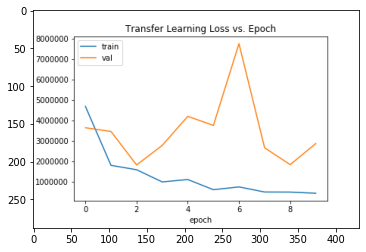

In [0]:
# import imageio
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
im = imageio.imread('/content/drive/My Drive/AM216/geospatial_analysis/history.png')
plt.imshow(im)

In [0]:
max_diff = 0;
real_pop = 0
predicted_pop = 0 
for i in tqdm(range(18)):
    x,y = next(train_generator)
    preds = transfer_model.predict(x)
    diff = np.abs(preds.flatten() - y)
    local_max = np.max(diff)
    if local_max > max_diff:
        max_diff = local_max
        real_pop = y[np.argmax(diff)]
        predicted_pop = preds[np.argmax(diff)]

In [0]:
pop_df[pop_df.population == 6652.0]


,filename,population
203,25017340100.png,6652.0


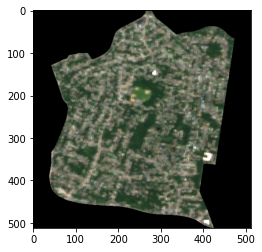

In [0]:
im = imageio.imread('/content/drive/My Drive/summer_resized/25017340100.png')
plt.imshow(im)

Here's the tract that our model performed the worst on. It looks like it's a large, suburban neighborhood. Perhaps the large amount of green space confused the model, and if we had a larger dataset and/or higher definition photos, the model would behave better. 

# Unsuccessful Forays
We made a number of attempts to improve the performance of our models.

## Adding area of tract as a second input
We thought that perhaps an issue with our data was the fact that each image of a tract was the same size, despite tracts ranging widely in size. Thus we created a new data generator which combined the image as well as the area of the tract. Below is the code for creating such a generator.



In [0]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split=0.2) 
def combined_generator(subset, width, height, batchsize):
    img_gen = train_datagen.flow_from_dataframe(dataframe=pop_df, directory=image_dir, 
                                              x_col="filename", y_col="population", has_ext=True, 
                                              class_mode="other", target_size=(width, height), 
                                              batch_size=batchsize,subset=subset, shuffle=True)
    while True:
      idx = (img_gen.batch_index) * img_gen.batch_size
      filenames = img_gen.filenames[idx : idx + img_gen.batch_size]
      area_list = pop_df[pop_df['filename'].isin(filenames)].area.values
      X1 = next(img_gen)
      yield ([X1[0],area_list], X1[1])
train_generator = combined_generator(subset='training', width=IMG_WIDTH, height=IMG_HEIGHT, batchsize=BATCH_SIZE)
validation_generator = combined_generator(subset='validation', width=IMG_WIDTH, height=IMG_HEIGHT, batchsize=BATCH_SIZE)

## Adding a learning rate scheduler to fit the models

We experimented with adding a learning rate scheduler to improver model performance. A learning scheduler audo-adjusts the learninng rate per epoch to performance at each epoch of training. For us, the learning rate scheduler started with a train learning rate of 0.001, and validation learning rate of 0.0001. we found that although it improved train MSE, it did not improve validation MSE at the same rate, resulting in overfitting. As a result, we left it out of our final models. You can incorporate a learning rate scheduler as demonstrated below.

In [0]:
# functions for learning rate scheduler
def get_lr_metric(optimizer): # to print out learning rate during model fitting
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

def scheduler(epoch): # exponential decay of learning rate
  initial_lrate = 0.0001
  if epoch < 5:
    lrate = initial_lrate
  else:
    lrate = initial_lrate*math.exp(0.1*(5-epoch))
  return lrate

# compile desired model
optimizer = Adam()
lr_metric = get_lr_metric(optimizer)
unet_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy', lr_metric])

# Define learning rate scheduler
lrate = LearningRateScheduler(scheduler)
callbacks_list = [lrate]

# Fit
unet_model_history = unet_model.fit(train_generator,
                          steps_per_epoch=STEP_SIZE_TRAIN,
                          validation_data = validation_generator,
                          validation_steps=STEP_SIZE_VALID, callbacks=callbacks_list, epochs=15)

# Discussion of Results
### Potential Pitfalls
A number of reasons may have hindered us. The highest resolution satellite image data is not free, and has more than 10x the resolution of the data that we used. In using this DigitalGlobe data, we could have conducted our analyses at the smaller "census block" level. Perhaps this would have been more successful, and the models would have learned more abou the nature of human habitation.

Given the time it took to train our models, we limited ourselves to data from Massachusetts, as opposed to the entire United States. It would have been more interesting to see how our approach fared on a broader dataset, and perhaps our models would have done better in this case, as there is only so much a model can learn from fewer than 2000 total images. 

Hence, computational power was a significant limitation, and though we attempted to get around it by spinning up GPU EC2 instances as opposed to training within colab, we still did not have access large, multi-GPU instance, which could have allowed us to look at more data.

Finally, there is the foundational difficulties that come with the problem of predicitng populations based on landscape images alone. For example, intuitively we might think of buildings as correlating with higher population density. This may be true in many places such as suburban neighborhoods or areas with dense apartment complex clusters, but financial districts in city centers may -- on the contrary -- be replete with buildings, but have near-zero population counts in the census. Put another way, what features readily distinguish an apartment skyscraper from a commercial office space skyscraper? 

### FFNN
We created a FFNN with only a few dense layers as a basleine model to compare our other prediction results to. We found that the model had a poor validation of loss of ~3752094, or in other words, each estimate of population was, on average, off by 1,937 people. We anticipated this model to perform poorly, as it was not tweaked for optimal performance.

### Simple CNN models

We found that the CNN models with fewer layers were able to predict population with less average population count error per census track than FFNN (average error of ~1500 people). We were surprised that the average error wasn't too far off, given the simple CNN archtiecture, and that the task of detecting highly populated areas purely from satellite images is relatively difficult. There were a decent amount of satellite images without much population (i.e. Western MA), and so we think that the model would more easily tell the difference between populated vs unpopulated areas. We think that the CNN models with less layers has a limit with how accuractely they could predict (could not achieve average population area less than ~1500 people), and so these models were limited. 

### Deep Sequential Model and UNet Models: 

The deep sequential and UNet models both consisted of more layers. The difference between the two is that the UNet model's decoder contains skip connection layers, which combine the output of feature maps of the encoder with previous convolution layers. We were disappointed to see that these deeper models did not boost the performance of the simpler models, again stalling around the same ~1500 limit as described for those more shallow models.

### Transfer Learning Model

The transfer learning model, built on top of MobileNet was the most performant of our models. It should still be noted that this peak performance is still an error range of +/- ~1000 people per tract, which still isn't great. However, this demonstrates the wide applicability of transfer learning, even when not attempting to do classification.


# Conclusion
Overall through this project, we were able to explore the GEE database, build a data pipeline to obtain the satellite images, perform data preprocssing to pad the satellite images and combine demographic data (from CenPy), and build multiple neural network models to predict population. To conclude, we were successful in building a pipeline and models that analyzed and predicted based off of satellite imagery. However, we found that training on ~1400 images was not enough for the model to learn weights that could accurately predict population. We also found that the quality of images affects performance, and that a more complex architecture (UNet model) does not necessarily outperform a simpler architecture (simple CNN models). Regardless of our models not performing incredibly well, we were able to experiment with different models and learn how to interact with GEE. We found the inverse problem of learning population from satellite images to be an interesting, challenging, and rewarding task to solve.
